In [ ]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
def load_txt_file(filename='Nat.txt'):
    try:
        data = pd.read_csv(filename, sep="\t", names=['date', 'prix'], dayfirst=True)
        data['prix'] = data['prix'].astype(str).str.replace(',', '.').astype(float)
        return data
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier: {e}")
        return None

def save_to_csv(df, filename='dataTd1Td2.csv'):
    try:
        df.to_csv(filename, index=False)
        print(f"Les données ont été sauvegardées dans le fichier {filename}.")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde: {e}")

data = load_txt_file()
if data is not None:
    save_to_csv(data)

Erreur lors de la lecture du fichier: [Errno 2] No such file or directory: 'Nat.txt'


In [ ]:
Natixis_Data = pd.read_csv("dataTd1Td2.csv")

returns = []

for i in range(1, len(Natixis_Data)):
    close_price_today = Natixis_Data['prix'][i]
    close_price_yesterday = Natixis_Data['prix'][i - 1]
    daily_return = (close_price_today - close_price_yesterday) / close_price_yesterday
    returns.append(daily_return)

data['Daily_Return'] = [None] + returns

print(returns)

[-0.03504714463618574, -0.01751474926253699, -0.019703509101144594, 0.04383614088820829, -0.020722538052448274, -0.014232209737827645, 0.025835866261398197, -0.016481481481481555, 0.02052344191301073, 0.013284132841328426, 0.02603787327021118, 0.016681455190772018, 0.006109268633269356, 0.032616238723108905, -0.008400537634408572, 0.00016943409013884205, -0.02066745722513974, -0.010205846739318332, 0.002970989164627658, -0.01515943544171454, 0.00406935598018395, 0.030132158590308416, -0.010263427984947057, -0.003629450397511218, 0.015091066782307136, -0.016404647983595366, 0.023974982626824164, -0.013742789277231151, 0.020643385515224516, 0.030844429462329317, -0.005068672334859335, 0.01610517666392767, 0.01196830017790714, 0.019817804059453503, -0.005955179438959451, 0.008986284092700676, 0.0007812499999999833, -0.008118657298985244, 0.014481347394931612, 0.003878975950349025, 0.005564142194745051, -0.020442668306178913, 0.007061038757257167, -0.0024929884699283287, 0.0049984379881287

In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data_k = data[(data['date'] >= '2015-01-01') & (data['date'] <= '2016-12-31')].dropna()

data_k.head(), data_k.tail()

(        date   prix  Daily_Return
 1 2015-01-05  5.424     -0.035047
 2 2015-01-06  5.329     -0.017515
 3 2015-01-07  5.224     -0.019704
 4 2015-01-08  5.453      0.043836
 5 2015-01-09  5.340     -0.020723,
           date   prix  Daily_Return
 508 2016-12-23  5.376     -0.008118
 509 2016-12-27  5.380      0.000744
 510 2016-12-28  5.379     -0.000186
 511 2016-12-29  5.328     -0.009481
 512 2016-12-30  5.360      0.006006)

Non-Parametric VaR (Biweight Kernel) at 95.0% confidence level: -0.0388


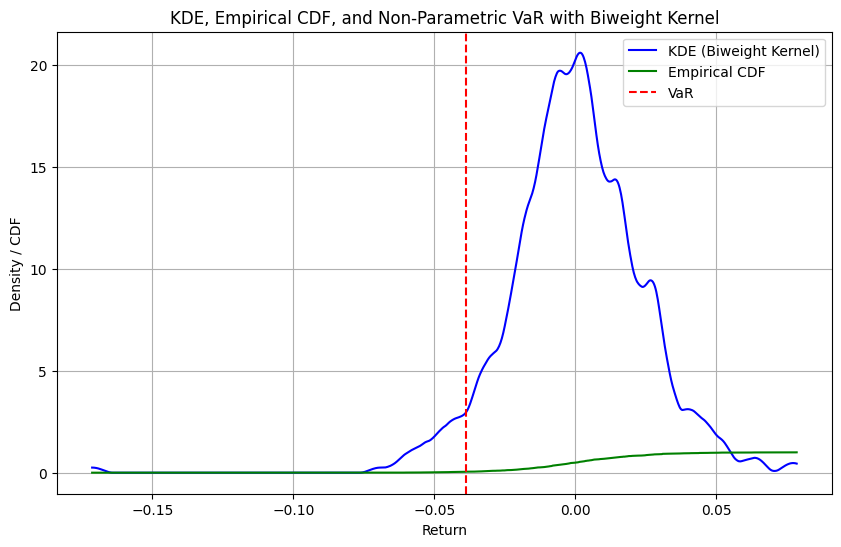

In [ ]:
returns_kernel = data_k['Daily_Return'].values

def biweight_kernel(u):
    abs_u = np.abs(u)
    mask = abs_u <= 1
    return (15/16) * (1 - u**2)**2 * mask

def kernel_density_estimate_biweight(x, data, h):
    n = len(data)
    u = (x - data) / h
    kde = np.sum(biweight_kernel(u)) / (n * h)
    return kde

n = len(returns_kernel)
h = 1.06 * np.std(returns_kernel) * (n ** (-1/5))

x_range = np.linspace(min(returns_kernel), max(returns_kernel), num=1000)

kde_values_biweight = [kernel_density_estimate_biweight(x, returns_kernel, h) for x in x_range]

def empirical_cdf(x, data):
    return np.sum(data <= x) / len(data)

cdf_values = [empirical_cdf(x, returns_kernel) for x in x_range]

probability_level = 0.95
non_parametric_var_biweight = None
for i, cdf in enumerate(cdf_values):
    if cdf >= (1 - probability_level):
        non_parametric_var_biweight = x_range[i]
        break

non_parametric_var_biweight_message = f"Non-Parametric VaR (Biweight Kernel) at {probability_level * 100}% confidence level: {non_parametric_var_biweight:.4f}"
print(non_parametric_var_biweight_message)

plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_values_biweight, label='density (Biweight Kernel)', color='blue')
plt.plot(x_range, cdf_values, label='Empirical CDF', color='green')
plt.axvline(x=non_parametric_var_biweight, color='red', linestyle='--', label='VaR')
plt.xlabel('Return')
plt.ylabel('Density / CDF')
plt.title('RCDF, and Non-Parametric VaR with Biweight Kernel')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data_2017 = data[(data['date'] >= '2017-01-01') & (data['date'] <= '2018-12-31')]

data_2017['Daily_Return'] = data_2017['prix'].pct_change()

data_filtered = data_2017.dropna()

var_threshold = -0.0388
exceedances = data_2017['Daily_Return'] < var_threshold
exceedance_proportion = exceedances.sum() / len(data_2017)

confidence_level = 0.95
expected_proportion = 1 - confidence_level
validation = exceedance_proportion <= expected_proportion

exceedance_proportion, validation

<ipython-input-10-cec6e1ead560>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2017['Daily_Return'] = data_2017['prix'].pct_change()


(0.01568627450980392, True)

# Question 2

In [ ]:
var = -0.0388
tail_losses = [loss for loss in returns_kernel if loss < var]

expected_shortfall = - (sum(tail_losses) / len(tail_losses))

print(f"The Expected Shortfall at 95% confidence level is: {expected_shortfall}")

The Expected Shortfall at 95% confidence level is: 0.05336181815045533


# Question 3

In [ ]:
data = pd.read_csv("dataTd1Td2.csv")

returns = []

for i in range(1, len(Natixis_Data)):
    close_price_today = Natixis_Data['prix'][i]
    close_price_yesterday = Natixis_Data['prix'][i - 1]
    daily_return = (close_price_today - close_price_yesterday) / close_price_yesterday
    returns.append(daily_return)

data['Daily_Return'] = [None] + returns

print(returns)

[-0.03504714463618574, -0.01751474926253699, -0.019703509101144594, 0.04383614088820829, -0.020722538052448274, -0.014232209737827645, 0.025835866261398197, -0.016481481481481555, 0.02052344191301073, 0.013284132841328426, 0.02603787327021118, 0.016681455190772018, 0.006109268633269356, 0.032616238723108905, -0.008400537634408572, 0.00016943409013884205, -0.02066745722513974, -0.010205846739318332, 0.002970989164627658, -0.01515943544171454, 0.00406935598018395, 0.030132158590308416, -0.010263427984947057, -0.003629450397511218, 0.015091066782307136, -0.016404647983595366, 0.023974982626824164, -0.013742789277231151, 0.020643385515224516, 0.030844429462329317, -0.005068672334859335, 0.01610517666392767, 0.01196830017790714, 0.019817804059453503, -0.005955179438959451, 0.008986284092700676, 0.0007812499999999833, -0.008118657298985244, 0.014481347394931612, 0.003878975950349025, 0.005564142194745051, -0.020442668306178913, 0.007061038757257167, -0.0024929884699283287, 0.0049984379881287

In [ ]:
gains = data['Daily_Return'][data['Daily_Return'] > 0]
sort_gains = np.sort(gains)

losses = data['Daily_Return'][data['Daily_Return'] < 0]
sort_losses = np.sort(abs(losses))

def pickands_estimator(extreme_values):
    n = len(extreme_values)
    k = int(np.log(n))
    return (1 / np.log(2)) * np.log((extreme_values[n-k+1] - extreme_values[n - 2*k + 1]) / (extreme_values[n - 2*k +1] - extreme_values[n - 4*k +1]))

shape_param_gains_pickands = pickands_estimator(sort_gains)
shape_param_losses_pickands = pickands_estimator(sort_losses)

shape_param_gains_pickands, shape_param_losses_pickands

(0.7031608888285327, -0.48226718380666683)

In [ ]:
def calculate_var(extreme_values, k, xi_p, confidence_level):
    n = len(extreme_values)
    p = 1 - confidence_level
    l = int(np.log(n))

    var_p = ((k / (n * (1 - p))) ** xi_p - 1) / (1 - 2 ** (-xi_p)) * (extreme_values[n-l+1] - extreme_values[n-2*l+1]) + extreme_values[n-l+1]
    return var_p


confidence_levels = [0.9, 0.95, 0.99]
vars_confidence_levels_gains = {cl: calculate_var(sort_gains, 1, shape_param_gains_pickands, cl) for cl in confidence_levels}
vars_confidence_levels_losses = {cl: calculate_var(sort_losses, 1, shape_param_losses_pickands, cl) for cl in confidence_levels}

print('gains var',vars_confidence_levels_gains)
print('losses var',vars_confidence_levels_losses)

gains var {0.9: 0.031226716623382784, 0.95: 0.031210095059210005, 0.99: 0.0311978341166503}
losses var {0.9: -0.24595507638458242, 0.95: -0.2544959672583297, 0.99: -0.26116242233901227}


# Question 4

In [ ]:
csv_data = pd.read_csv("Dataset TD4.csv", delimiter=";")

volume = []
transaction_price = []
transaction_sign = []

for i in range(len(csv_data) - 2):
    if pd.notna(csv_data['volume of the transaction (if known)'].iloc[i]):
        volume.append(csv_data['volume of the transaction (if known)'].iloc[i])
        transaction_price.extend([csv_data['Price (before transaction)'].iloc[i], csv_data['Price (before transaction)'].iloc[i + 1]])
        transaction_sign.append(csv_data['Sign of the transaction'].iloc[i])

returns = [(transaction_price[i + 1] - transaction_price[i]) / transaction_price[i] for i in range(len(transaction_price) - 1)]
returns = np.array(returns)

sigma = np.std(returns) * np.sqrt(24) * np.sqrt(252)  # 24 pour les heures par jour, 252 pour les jours de trading par an
sigma

0.10712235648487789

In [ ]:
total_volume = np.sum(volume)

time_interval = 1/24

price_difference = np.array([transaction_price[i+1] - transaction_price[i] for i in range(0, len(transaction_price) - 1, 2)])
signed_volume = np.array([volume[i] * transaction_sign[i] for i in range(len(volume))])
volume_squared_signed = np.array([transaction_sign[i] * volume[i] ** 2 for i in range(len(price_difference))])

modified_price_gamma = price_difference
modified_price_êtha = -price_difference
X_gamma_mod = signed_volume.reshape(-1,1)
X_êtha_mod = np.column_stack((signed_volume, volume_squared_signed))

total_volume, modified_price_gamma[:5], modified_price_êtha[:5], X_gamma_mod[:5], X_êtha_mod[:5]

(14828.0,
 array([-0.016,  0.026, -0.019, -0.075, -0.086]),
 array([ 0.016, -0.026,  0.019,  0.075,  0.086]),
 array([[  -8.],
        [  32.],
        [  -8.],
        [-141.],
        [-121.]]),
 array([[-8.0000e+00, -6.4000e+01],
        [ 3.2000e+01,  1.0240e+03],
        [-8.0000e+00, -6.4000e+01],
        [-1.4100e+02, -1.9881e+04],
        [-1.2100e+02, -1.4641e+04]]))


Estimation gamma : 0.0005023480698709213
MSE : 0.0004939145394206074 ; R^2 : 0.9193657542903342


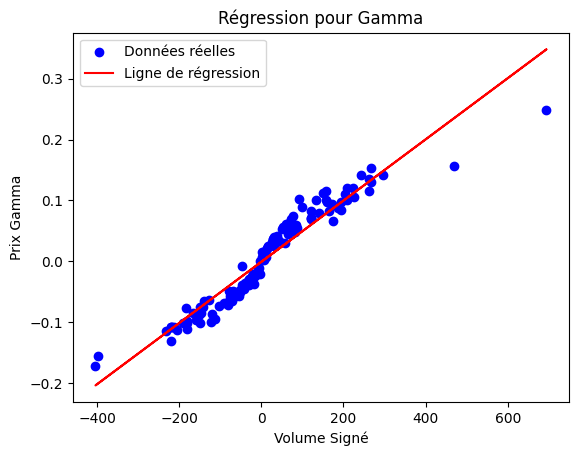

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def linear_regression_np(X, y):
    X_mean = np.mean(X)
    y_mean = np.mean(y)

    slope = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean)**2)

    intercept = y_mean - slope * X_mean

    return slope, intercept

X_gamma_array = np.array(X_gamma_mod[:, 0])
prix_gamma_array = np.array(modified_price_gamma)

slope_gamma, intercept_gamma = linear_regression_np(X_gamma_array, prix_gamma_array)

y_pred_gamma = slope_gamma * X_gamma_array + intercept_gamma
mse_gamma = np.mean((prix_gamma_array - y_pred_gamma)**2)
r2_gamma = 1 - sum((prix_gamma_array - y_pred_gamma)**2) / sum((prix_gamma_array - np.mean(prix_gamma_array))**2)

print(f"\nEstimation gamma : {slope_gamma}")
print(f"MSE : {mse_gamma} ; R^2 : {r2_gamma}")

plt.scatter(X_gamma_array, prix_gamma_array, color="blue", label="Données réelles")
plt.plot(X_gamma_array, y_pred_gamma, color="red", label="Ligne de régression")
plt.xlabel("Volume Signé")
plt.ylabel("Prix Gamma")
plt.title("Régression pour Gamma")
plt.legend()
plt.show()


Estimation êtha : 5.966990046987537e-08
MSE : 0.006125369377162789 ; R^2 : -135.00000000000003


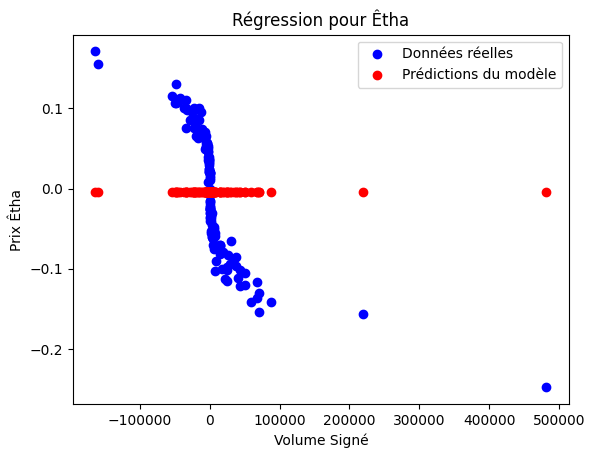

In [ ]:
X_êtha_array = np.array(X_gamma_mod)
prix_êtha_array = np.array(modified_price_êtha)

coefficients_êtha, intercept_êtha = linear_regression_np(X_êtha_array, prix_êtha_array)

y_pred_gamma = slope_gamma * X_gamma_array + intercept_gamma

y_pred_êtha = coefficients_êtha * X_êtha_array + intercept_êtha
#mmse_êtha = np.mean((prix_êtha_array - y_pred_êtha)**2)


mse_êtha = np.mean((prix_êtha_array - y_pred_êtha)**2)


ss_res = np.sum((prix_êtha_array - y_pred_êtha)**2)
ss_tot = np.sum((prix_êtha_array - np.mean(prix_êtha_array))**2)
r2_êtha = 1 - (ss_res / ss_tot)

#êtha = coefficients_êtha[1] # Etha est le second coefficient
print(f"\nEstimation êtha : {êtha}")
print(f"MSE : {mse_êtha} ; R^2 : {r2_êtha}")

plt.scatter(volume_squared_signed, prix_êtha_array, color="blue", label="Données réelles")
plt.scatter(volume_squared_signed, y_pred_êtha, color="red", label="Prédictions du modèle")
plt.xlabel("Volume Signé")
plt.ylabel("Prix Êtha")
plt.title("Régression pour Êtha")
plt.legend()
plt.show()


Estimation êtha : 5.966990046987537e-08
MSE : 0.0005281376783129514 ; R^2 : 0.913778639981777


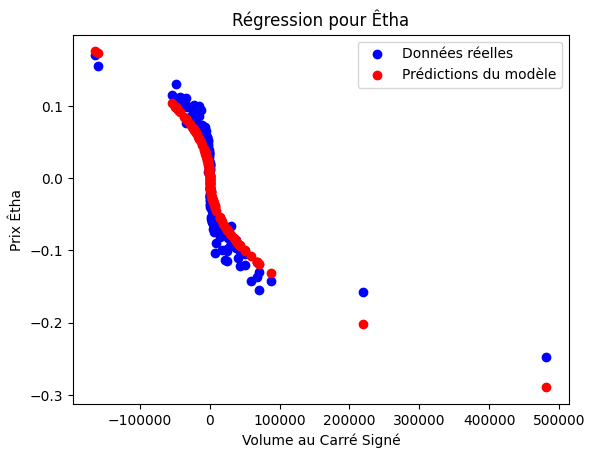

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def linear_regression_multivariate(X, y):
    X_mean = np.mean(X, axis=0)
    y_mean = np.mean(y)

    # Calcul de la pente (slope) et de l'ordonnée à l'origine (intercept) pour une régression multivariée
    X_cov = np.dot(X.T, X) - np.sum(X, axis=0) * X_mean
    X_cov_inv = np.linalg.inv(X_cov)
    X_X_mean_y_mean = np.dot(X.T, y) - np.sum(X, axis=0) * y_mean
    coefficients = np.dot(X_cov_inv, X_X_mean_y_mean)

    intercept = y_mean - np.dot(coefficients.T, X_mean)

    return coefficients, intercept

X_êtha_array = np.column_stack((X_gamma_mod, volume_squared_signed))
prix_êtha_array = np.array(modified_price_êtha)

coefficients_êtha, intercept_êtha = linear_regression_multivariate(X_êtha_array, prix_êtha_array)

y_pred_êtha = np.dot(X_êtha_array, coefficients_êtha) + intercept_êtha
mse_êtha = np.mean((prix_êtha_array - y_pred_êtha)**2)
r2_êtha = 1 - sum((prix_êtha_array - y_pred_êtha)**2) / sum((prix_êtha_array - np.mean(prix_êtha_array))**2)

êtha = coefficients_êtha[1] # Etha est le second coefficient
print(f"\nEstimation êtha : {êtha}")
print(f"MSE : {mse_êtha} ; R^2 : {r2_êtha}")

plt.scatter(volume_squared_signed, prix_êtha_array, color="blue", label="Données réelles")
plt.scatter(volume_squared_signed, y_pred_êtha, color="red", label="Prédictions du modèle")
plt.xlabel("Volume au Carré Signé")
plt.ylabel("Prix Êtha")
plt.title("Régression pour Êtha")
plt.legend()
plt.show()

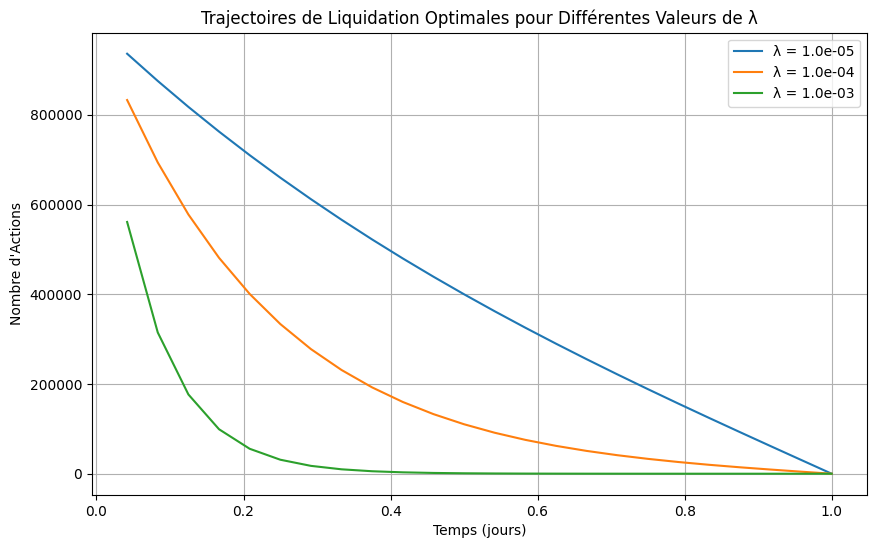

In [ ]:
X = 1000000
T = [(1/24) * i for i in range(1, 25)]

Lambda_values = [1*10**(-5), 1*10**(-4), 1*10**(-3)]


# Calcul de K pour chaque valeur de lambda et tracé des stratégies de liquidation
plt.figure(figsize=(10, 6))
for Lambda in Lambda_values:
    K = np.sqrt(Lambda * (sigma**2) / êtha)
    strat = [np.sinh(K * (1 - t)) * X / np.sinh(K * 1) for t in T]
    plt.plot(T, strat, label=f'λ = {Lambda:.1e}')

plt.title('Trajectoires de Liquidation Optimales pour Différentes Valeurs de λ')
plt.xlabel('Temps (jours)')
plt.ylabel('Nombre d\'Actions')
plt.legend()
plt.grid(True)
plt.show()

# Question 5

In [ ]:
import pandas as pd
import numpy as np

Currencies = pd.read_csv("Dataset-TD5-csv.csv")

# Split du dataset et calcul des moyennes
GBPEUR = Currencies.iloc[:,:3]
SEKEUR = Currencies.iloc[:,3:6]
CADEUR = Currencies.iloc[:,6:]


GBPEUR['GBPEUR AVG'] = GBPEUR.iloc[:, [1, 2]].mean(axis=1)
SEKEUR['SEKEUR AVG'] = SEKEUR.iloc[:, [1, 2]].mean(axis=1)
CADEUR['CADEUR AVG'] = CADEUR.iloc[:, [1, 2]].mean(axis=1)

# On verif que nous disposons des 512 derniers points de données (après avoir supprimé les valeurs manquantes) proches de 672, ce qui équivaut à 7 * 96.
GBPEUR = GBPEUR.iloc[-513:]
SEKEUR = SEKEUR.iloc[-513:]
CADEUR = CADEUR.iloc[-513:]

GBPEUR_returns = GBPEUR['GBPEUR AVG'].pct_change().dropna()
SEKEUR_returns = SEKEUR['SEKEUR AVG'].pct_change().dropna()
CADEUR_returns = CADEUR['CADEUR AVG'].pct_change().dropna()

def haar_transform(data):
    n = len(data)
    output = np.zeros(n)
    while n > 1:
        n = n // 2
        for i in range(n):
            output[i] = (data[2 * i] + data[2 * i + 1]) / 2
            output[n + i] = (data[2 * i] - data[2 * i + 1]) / 2
        data[:n] = output[:n]
    return output

def multiresolution_correlation(haar1, haar2, level):
    length = 2 ** level
    truncated_haar1 = haar1[:length]
    truncated_haar2 = haar2[:length]
    return np.corrcoef(truncated_haar1, truncated_haar2)[0, 1]

def correlation_matrix_at_level(level, haar_transforms):
    matrix_size = len(haar_transforms)
    correlation_matrix = np.zeros((matrix_size, matrix_size))
    for i in range(matrix_size):
        for j in range(i, matrix_size):
            if i == j:
                correlation_matrix[i, j] = 1
            else:
                correlation = multiresolution_correlation(haar_transforms[i], haar_transforms[j], level)
                correlation_matrix[i, j] = correlation_matrix[j, i] = correlation
    return correlation_matrix

gbpeur_haar = haar_transform(GBPEUR_returns.values)
sekeur_haar = haar_transform(SEKEUR_returns.values)
cadeur_haar = haar_transform(CADEUR_returns.values)

num_levels = 9

haar_transforms = [gbpeur_haar, sekeur_haar, cadeur_haar]
correlation_matrices = [correlation_matrix_at_level(level, haar_transforms) for level in range(num_levels)]

correlation_matrix_j9 = correlation_matrices[-1]
correlation_matrix_j9

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


array([[ 1.        ,  0.03026039,  0.23888535],
       [ 0.03026039,  1.        , -0.04813272],
       [ 0.23888535, -0.04813272,  1.        ]])

In [ ]:
import math as m

def Hurst(serie):
    T = len(serie)
    M2 = np.mean((abs(serie[1:] - serie[:-1]))**2)
    M2_prime = np.mean(abs((serie[2:] - serie[:-2]))**2)
    H_est = 0.5 * m.log2(M2_prime / M2)
    return H_est

hurst_gbpeur = Hurst(GBPEUR['GBPEUR AVG'].values)
hurst_sekeur = Hurst(SEKEUR['SEKEUR AVG'].values)
hurst_cadeur = Hurst(CADEUR['CADEUR AVG'].values)
#hurst_gbpeur = Hurst(GBPEUR_returns.values)
#hurst_sekeur = Hurst(SEKEUR_returns.values)
#hurst_cadeur = Hurst(CADEUR_returns.values)

hurst_gbpeur, hurst_sekeur, hurst_cadeur

(0.6980759205067774, 0.6583244952455628, 0.6974012762332173)

In [ ]:
vol_gbpeur_hf = np.std(GBPEUR_returns)
vol_sekeur_hf = np.std(SEKEUR_returns)
vol_cadeur_hf = np.std(CADEUR_returns)

volatility_gbpeur = []
volatility_sekeur = []
volatility_cadeur = []

num_levels = 9
for j in range(num_levels):
    periods = 2 ** j
    volatility_gbpeur.append(vol_gbpeur_hf * (periods ** hurst_gbpeur))
    volatility_sekeur.append(vol_sekeur_hf * (periods ** hurst_sekeur))
    volatility_cadeur.append(vol_cadeur_hf * (periods ** hurst_cadeur))

volatility_gbpeur, volatility_sekeur, volatility_cadeur

([0.00035638848198640225,
  0.0005781831769083096,
  0.0009380095119699755,
  0.0015217700543467794,
  0.002468827947643163,
  0.004005277550083138,
  0.006497920711127125,
  0.010541834626970713,
  0.017102436647479832],
 [0.0001826097112358074,
  0.000288203525878771,
  0.0004548568187685091,
  0.0007178771493143907,
  0.001132988624646809,
  0.0017881377402875014,
  0.0028221259319679767,
  0.004454016374938535,
  0.007029545224577071],
 [0.000305828418636186,
  0.0004959256169324979,
  0.0008041836616316936,
  0.0013040491145336105,
  0.0021146215401410657,
  0.003429030554288469,
  0.0055604515129735665,
  0.009016723688700322,
  0.014621349703109262])

In [ ]:
num_levels = 9
correlation_matrices = [correlation_matrix_at_level(level, [gbpeur_haar, sekeur_haar, cadeur_haar]) for level in range(num_levels)]

volatility_gbpeur = [vol_gbpeur_hf * (2**j)**hurst_gbpeur for j in range(num_levels)]
volatility_sekeur = [vol_sekeur_hf * (2**j)**hurst_sekeur for j in range(num_levels)]
volatility_cadeur = [vol_cadeur_hf * (2**j)**hurst_cadeur for j in range(num_levels)]

covariance_matrices = []

for j in range(num_levels):
    correlation_matrix = correlation_matrices[j]

    covariance_matrix = np.zeros((3, 3))

    volatilities = [volatility_gbpeur[j], volatility_sekeur[j], volatility_cadeur[j]]
    for i in range(3):
        for k in range(3):
            covariance_matrix[i, k] = correlation_matrix[i, k] * volatilities[i] * volatilities[k]

    covariance_matrices.append(covariance_matrix)

# Supposons que covariance_matrices est la liste de vos matrices de covariance
covariance_matrices = [np.nan_to_num(matrix) for matrix in covariance_matrices]

covariance_matrix = covariance_matrices[0]
print(covariance_matrix)

[[1.27012750e-07 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.33463066e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.35310216e-08]]


In [ ]:
W = np.array([1/3, 1/3, 1/3])

portfolio_volatility = []

for covariance_matrix in covariance_matrices:
    portfolio_variance = np.dot(W.T, np.dot(covariance_matrix, W))
    portfolio_volatility.append(np.sqrt(portfolio_variance))


#portfolio_volatility
portfolio_volatility_j9 = portfolio_volatility[8]
portfolio_annual = np.sqrt(52) * portfolio_volatility_j9 ##juste pour vérifier
portfolio_annual

0.062336311918749165

In [ ]:
import scipy.stats as stats

Currencies = pd.read_csv("Dataset-TD5-csv.csv")

Currencies = Currencies.iloc[-513:]


GBPEUR = Currencies.iloc[:,:3]
SEKEUR = Currencies.iloc[:,3:6]
CADEUR = Currencies.iloc[:,6:]

GBPEUR['GBPEUR AVG'] = GBPEUR.iloc[:, [1, 2]].mean(axis=1)
SEKEUR['SEKEUR AVG'] = SEKEUR.iloc[:, [1, 2]].mean(axis=1)
CADEUR['CADEUR AVG'] = CADEUR.iloc[:, [1, 2]].mean(axis=1)
Currencies['Portfolio AVG'] = (GBPEUR['GBPEUR AVG'] + SEKEUR['SEKEUR AVG'] + CADEUR['CADEUR AVG'] )/3

# On definit le nombre de lines par echélle de temps
lines_per_scale = {
    '15min': 1,
    '1hour': 4,
    '1day': 96,
    # on peut en ajouter plus si on veut
}

# On définit la window_size pour du bi-journalier
window_size = 2 * lines_per_scale['1day']

# overlapping
overlapping_vols = []
for i in range(0, len(Currencies) - window_size + 1):
    window_returns = Currencies['Portfolio AVG'][i:i + window_size].pct_change().dropna()
    vol = np.std(window_returns)
    overlapping_vols.append(vol)


annualized_overlap = np.mean(overlapping_vols) * np.sqrt(252 / window_size)
scaling_factor = 100
annualized_overlap_scaled = annualized_overlap * scaling_factor


print("Bi-Journalier - Volatility:")
print(f"Bi-Journalier - Overlapping Volatility: {annualized_overlap_scaled}")

Bi-Journalier - Volatility:
Bi-Journalier - Overlapping Volatility: 0.038164407408753244


In [ ]:
# Calcule du delta (horizon / nombre de données)
delta = window_size / len(Currencies)
print(f"Delta (Horizon / Nombre de données): {delta}") # Pour que l'estimation est du sens delta < 68% ici c'est bien le cas

Delta (Horizon / Nombre de données): 0.3742690058479532


In [ ]:
from scipy.stats import jarque_bera
# Le but est de verifier la propriété de Lo et Mackinlay. On va le faire à l'aide d'un test de Jarque et Berra

# Calcul de la variance de overlapping_vols
var_overlapping_vols = np.var(overlapping_vols)

# Calcul de M(H)
M_H = var_overlapping_vols / (annualized_overlap ** 2)

# Nombre d'observations
T = len(overlapping_vols)

# Valeur de H
H = window_size

# Calcul de la statistique de test
test_statistic, p_value = jarque_bera(np.sqrt(T) * (M_H - H))

alpha = 0.05

if p_value < alpha:
    print("Le test rejette l'hypothèse de normalité.")
else:
    print("Le test n'a pas suffisamment de preuves pour rejeter l'hypothèse de normalité.")

Le test n'a pas suffisamment de preuves pour rejeter l'hypothèse de normalité.
